## ECE 225 Final Project: Loan Elibigility


### Import Dataset from Kaggle

In [ ]:
pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, accuracy_score, classification_report, roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



%matplotlib inline

/Users/sarahyang/IdeaProjects/leetcode/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# download latest version
path = kagglehub.dataset_download("devzohaib/eligibility-prediction-for-loan")


# rename the dataset file to train.csv
for file_name in os.listdir(path):
    if file_name.endswith(".csv"):  
        original_file_path = os.path.join(path, file_name)
        renamed_file_path = os.path.join(path, "train.csv")
        os.rename(original_file_path, renamed_file_path)
        break

# read the data
data = pd.read_csv(os.path.join(path, "train.csv"))
print(data.head())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

### Data Exploration

In [4]:
# we have 12 attributes, each have some missing values
data.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
# we get some simple statistics from attributes that have data-type of float or int
data.describe() 

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
# proportion of each class
class_counts = data['Loan_Status'].value_counts()

# counts
print("Class Counts:")
print(class_counts)

# percentages
class_percentages = data['Loan_Status'].value_counts(normalize=True) * 100
print("\nClass Percentages:")
print(class_percentages)


Class Counts:
Loan_Status
Y    422
N    192
Name: count, dtype: int64

Class Percentages:
Loan_Status
Y    68.729642
N    31.270358
Name: proportion, dtype: float64


### Feature Engineering

In [7]:
# create new attribute
data['Total_Income']=data['ApplicantIncome'] + data['CoapplicantIncome']

data.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)
print(data.head())

# drop Loan_ID col
data.drop(columns=['Loan_ID'], inplace=True)

    Loan_ID Gender Married Dependents     Education Self_Employed  LoanAmount  \
0  LP001002   Male      No          0      Graduate            No         NaN   
1  LP001003   Male     Yes          1      Graduate            No       128.0   
2  LP001005   Male     Yes          0      Graduate           Yes        66.0   
3  LP001006   Male     Yes          0  Not Graduate            No       120.0   
4  LP001008   Male      No          0      Graduate            No       141.0   

   Loan_Amount_Term  Credit_History Property_Area Loan_Status  Total_Income  
0             360.0             1.0         Urban           Y        5849.0  
1             360.0             1.0         Rural           N        6091.0  
2             360.0             1.0         Urban           Y        3000.0  
3             360.0             1.0         Urban           Y        4941.0  
4             360.0             1.0         Urban           Y        6000.0  


In [8]:
# handle missing data

# cols with missing values
cat_cols_with_na = ['Gender', 'Dependents', 'Self_Employed']
num_cols_with_na = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# fill missing values for cat vars with mode
for col in cat_cols_with_na:
    data[col] = data[col].fillna(data[col].mode()[0])


# fill missing values for numerical vars with mean
for col in num_cols_with_na:
    data[col] = data[col].fillna(data[col].mean())
    
print(data.isnull().sum())


Gender              0
Married             3
Dependents          0
Education           0
Self_Employed       0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
Property_Area       0
Loan_Status         0
Total_Income        0
dtype: int64


In [9]:
# encode categorical variables
# one-hot encode 
data = pd.get_dummies(data, columns=['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area'], drop_first=True)

# encode binary variables
label_encoder = LabelEncoder()
data['Loan_Status'] = label_encoder.fit_transform(data['Loan_Status'])  # 1 for Yes, 0 for No
data['Dependents'] = data['Dependents'].replace('3+', 3).astype(int)  # Convert '3+' to 3


Skewness Before Transformation:
LoanAmount          2.726601
Loan_Amount_Term   -2.389680
Total_Income        5.633449
dtype: float64


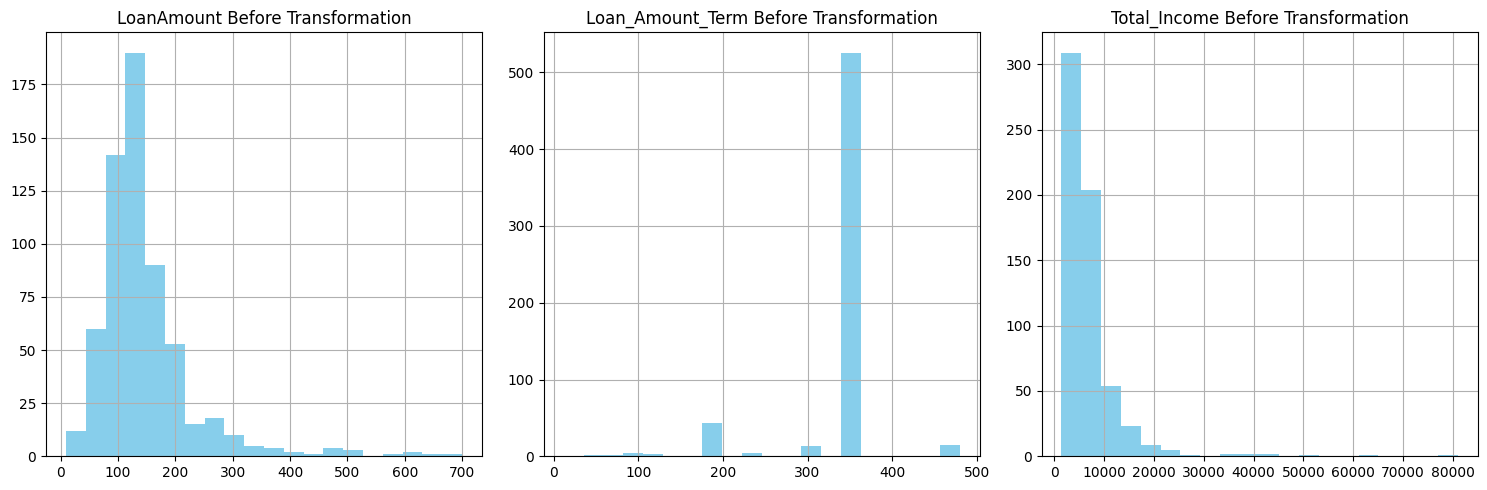


Skewness After Transformation:
Log_LoanAmount                   -0.179713
Power_TotalIncome                -0.034636
Log_Reflected_Loan_Amount_Term   -4.855097
dtype: float64


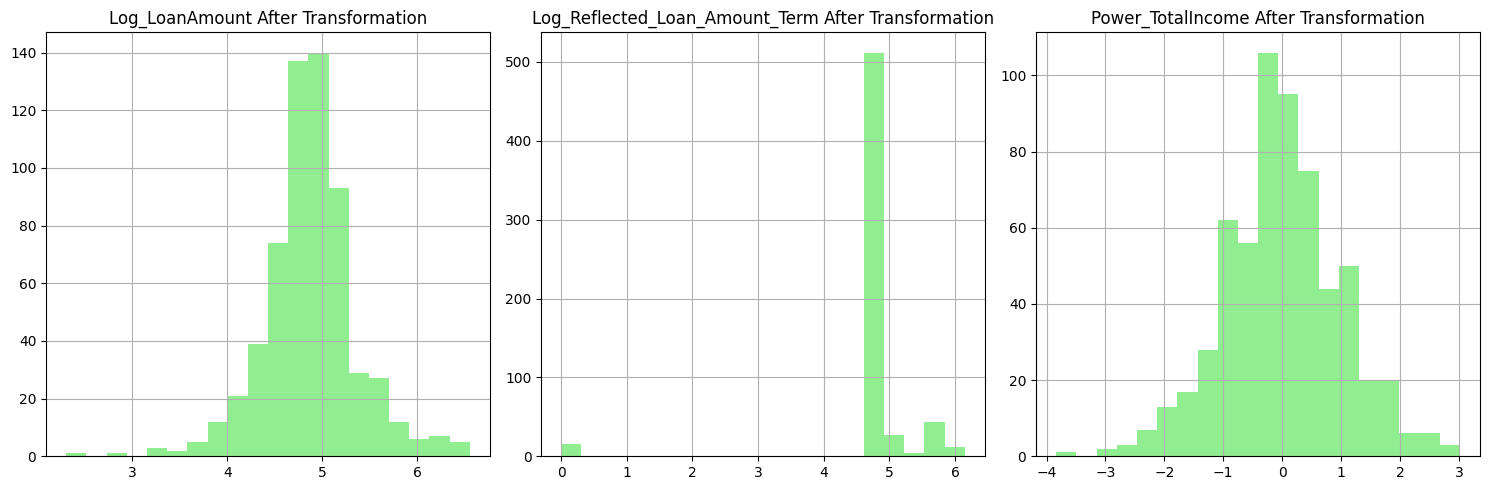

In [10]:
# check skewness for numerical vars
print("Skewness Before Transformation:")
print(data[['LoanAmount', 'Loan_Amount_Term', 'Total_Income']].skew())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
data['LoanAmount'].hist(bins=20, ax=axes[0], color='skyblue')
axes[0].set_title('LoanAmount Before Transformation')
data['Loan_Amount_Term'].hist(bins=20, ax=axes[1], color='skyblue')
axes[1].set_title('Loan_Amount_Term Before Transformation')
data['Total_Income'].hist(bins=20, ax=axes[2], color='skyblue')
axes[2].set_title('Total_Income Before Transformation')
plt.tight_layout()
plt.show()

# log transformation for LoanAmount
data['Log_LoanAmount'] = np.log1p(data['LoanAmount'])  

# power transformation for Total_Income
pt = PowerTransformer(method='yeo-johnson')  
data['Power_TotalIncome'] = pt.fit_transform(data[['Total_Income']]).flatten()  

# reflect for negative skewness and do log transform
data['Reflected_Loan_Amount_Term'] = data['Loan_Amount_Term'].max() - data['Loan_Amount_Term']
data['Log_Reflected_Loan_Amount_Term'] = np.log1p(data['Reflected_Loan_Amount_Term'])

print("\nSkewness After Transformation:")
print(data[['Log_LoanAmount', 'Power_TotalIncome', 'Log_Reflected_Loan_Amount_Term']].skew())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
data['Log_LoanAmount'].hist(bins=20, ax=axes[0], color='lightgreen')
axes[0].set_title('Log_LoanAmount After Transformation')
pd.Series(data['Log_Reflected_Loan_Amount_Term']).hist(bins=20, ax=axes[1], color='lightgreen')  # Convert to Series for plotting
axes[1].set_title('Log_Reflected_Loan_Amount_Term After Transformation')
data['Power_TotalIncome'].hist(bins=20, ax=axes[2], color='lightgreen')
axes[2].set_title('Power_TotalIncome After Transformation')
plt.tight_layout()
plt.show()

data.drop(columns=['LoanAmount', 'Loan_Amount_Term', 'Total_Income', 'Reflected_Loan_Amount_Term'], inplace=True)

# scale features
scaler = StandardScaler()
transformed_cols = ['Log_LoanAmount', 'Power_TotalIncome', 'Log_Reflected_Loan_Amount_Term']
data[transformed_cols] = scaler.fit_transform(data[transformed_cols])



## Logistic Regression Model

In [11]:
# features and target variable
features = data.drop(columns=['Loan_Status'])
target = data['Loan_Status']
strat_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=2023)

recall_list = []
accuracy_list = []
fold_number = 1

tprs = []  # true positive 
mean_fpr = np.linspace(0, 1, 100)  # false positive
auc_list = []

# stratified 4-folds cross validation
for train_idx, test_idx in strat_kfold.split(features, target):
    print(f"\nProcessing Fold {fold_number}:")

    # training and validation sets
    X_fold_train, X_fold_val = features.iloc[train_idx], features.iloc[test_idx]
    y_fold_train, y_fold_val = target.iloc[train_idx], target.iloc[test_idx]

    # logistic regression 
    logistic_model = LogisticRegression(random_state=2023)
    logistic_model.fit(X_fold_train, y_fold_train)
    val_predictions = logistic_model.predict(X_fold_val)
    val_probabilities = logistic_model.predict_proba(X_fold_val)[:, 1]  
    recall_metric = recall_score(y_fold_val, val_predictions)
    accuracy_metric = accuracy_score(y_fold_val, val_predictions)
    recall_list.append(recall_metric)
    accuracy_list.append(accuracy_metric)

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_fold_val, val_probabilities)
    roc_auc = auc(fpr, tpr)
    auc_list.append(roc_auc)

    # interpolate true pos
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0  

    print(f"  Recall for Fold {fold_number}: {recall_metric:.2f}")
    print(f"  Accuracy for Fold {fold_number}: {accuracy_metric:.2f}")
    print(f"  AUC for Fold {fold_number}: {roc_auc:.2f}")
    fold_number += 1

average_recall = np.mean(recall_list)
average_accuracy = np.mean(accuracy_list)
average_auc = np.mean(auc_list)

print(f"\nOverall Mean Recall: {average_recall:.4f}")
print(f"Overall Mean Accuracy: {average_accuracy:.4f}")



Processing Fold 1:
  Recall for Fold 1: 0.96
  Accuracy for Fold 1: 0.81
  AUC for Fold 1: 0.77

Processing Fold 2:
  Recall for Fold 2: 0.99
  Accuracy for Fold 2: 0.84
  AUC for Fold 2: 0.81

Processing Fold 3:
  Recall for Fold 3: 0.95
  Accuracy for Fold 3: 0.78
  AUC for Fold 3: 0.71

Processing Fold 4:
  Recall for Fold 4: 0.99
  Accuracy for Fold 4: 0.79
  AUC for Fold 4: 0.77

Overall Mean Recall: 0.9739
Overall Mean Accuracy: 0.8045


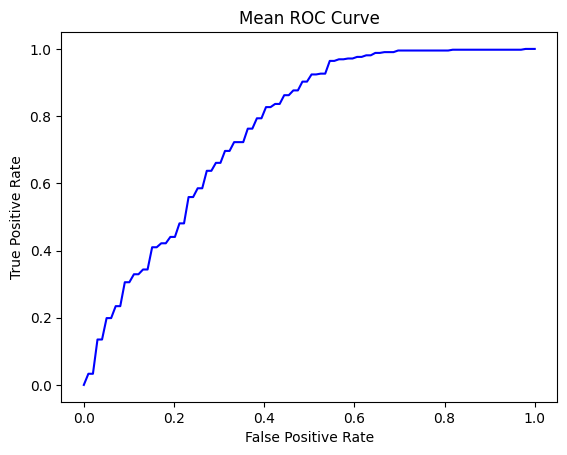

Mean AUC: 0.7637


In [12]:
# ROC curve
plt.figure()
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(auc_list)
plt.plot(mean_fpr, mean_tpr, color='b')  # Removed the label
plt.title("Mean ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()
print(f"Mean AUC: {mean_auc:.4f}")


### Random Forest ###

In [13]:
# features and target variable
X = data.drop('Loan_Status', axis=1)
y = data['Loan_Status']
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=2)

recall_scores = []
accuracy_scores = []
auc_values = []
tprs = []  
mean_fpr = np.linspace(0, 1, 100)  # uniform fpr for interpolation
fold = 1

# Stratified 4-Folds Cross-Validation
for train_index, val_index in kf.split(X, y):
    print(f"\nFold {fold}:")

    # training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # random forest classifier
    rf_model = RandomForestClassifier(random_state=1, n_estimators=10, class_weight='balanced')
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)
    y_pred_prob = rf_model.predict_proba(X_val)[:, 1]
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_prob)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)
    auc_values.append(auc)

    print(f"  Recall: {recall:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))  
    tprs[-1][0] = 0.0  
    fold += 1

mean_recall = np.mean(recall_scores)
mean_accuracy = np.mean(accuracy_scores)
mean_auc = np.mean(auc_values)
print(f"\nMean Recall: {mean_recall:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean AUC: {mean_auc:.4f}")





Fold 1:
  Recall: 0.8113
  Accuracy: 0.7727
  AUC: 0.7840

Fold 2:
  Recall: 0.9623
  Accuracy: 0.8182
  AUC: 0.7519

Fold 3:
  Recall: 0.9143
  Accuracy: 0.7712
  AUC: 0.7024

Fold 4:
  Recall: 0.8857
  Accuracy: 0.7582
  AUC: 0.7475

Mean Recall: 0.8934
Mean Accuracy: 0.7801
Mean AUC: 0.7464


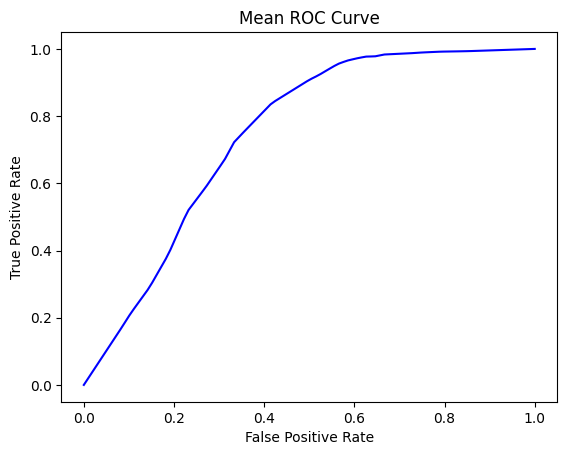

Mean AUC: 0.7464


In [14]:
from sklearn.metrics import auc

# mean ROC curve
plt.figure()
mean_tpr = np.mean(tprs, axis=0)  # average true pos 
mean_tpr[-1] = 1.0  
mean_auc = auc(mean_fpr, mean_tpr)  
std_auc = np.std(auc_values)  
plt.plot(mean_fpr, mean_tpr, color='b')  

plt.title("Mean ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

print(f"Mean AUC: {mean_auc:.4f}")


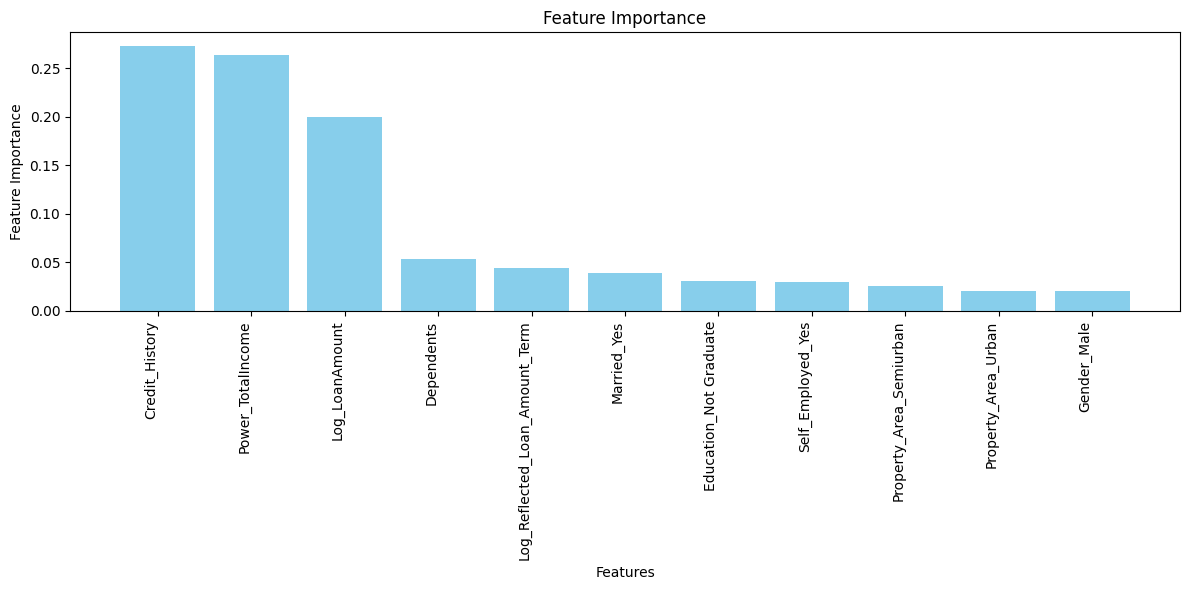

In [15]:
# feature importance and feature names
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# vertical bar plot
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.ylabel("Feature Importance")
plt.xlabel("Features")
plt.title("Feature Importance")
plt.xticks(rotation=90, ha='right')  # Rotate feature names for better readability
plt.tight_layout()
plt.show()


### XGBoost

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Dependents                      614 non-null    int64  
 1   Credit_History                  614 non-null    float64
 2   Loan_Status                     614 non-null    int64  
 3   Gender_Male                     614 non-null    bool   
 4   Married_Yes                     614 non-null    bool   
 5   Education_Not Graduate          614 non-null    bool   
 6   Self_Employed_Yes               614 non-null    bool   
 7   Property_Area_Semiurban         614 non-null    bool   
 8   Property_Area_Urban             614 non-null    bool   
 9   Log_LoanAmount                  614 non-null    float64
 10  Power_TotalIncome               614 non-null    float64
 11  Log_Reflected_Loan_Amount_Term  614 non-null    float64
dtypes: bool(6), float64(4), int64(2)
mem

In [17]:
X = data.drop(columns=['Loan_Status'])
y = data['Loan_Status']

# stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

recall_scores = []
accuracy_scores = []
auc_values = []
tprs = []  
mean_fpr = np.linspace(0, 1, 100)  
fold = 1  

for train_index, val_index in kf.split(X, y):
    print(f"\nProcessing Fold {fold}:")

    # train and validation
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # XGBoost classifier
    xgb_model = XGBClassifier(
        random_state=42,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    y_pred_prob = xgb_model.predict_proba(X_val)[:, 1]

    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    auc_value = roc_auc_score(y_val, y_pred_prob)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)
    auc_values.append(auc_value)
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolate TPR to match mean FPR
    tprs[-1][0] = 0.0  # Ensure TPR starts at 0

    print(f"  Recall: {recall:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC: {auc_value:.4f}")

    fold += 1  # Increment fold counter

mean_recall = np.mean(recall_scores)
mean_accuracy = np.mean(accuracy_scores)
mean_auc = np.mean(auc_values)

print(f"\nMean Recall: {mean_recall:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean AUC: {mean_auc:.4f}")





Processing Fold 1:
  Recall: 0.8868
  Accuracy: 0.7597
  AUC: 0.7344

Processing Fold 2:
  Recall: 0.8868
  Accuracy: 0.8052
  AUC: 0.7700

Processing Fold 3:
  Recall: 0.8857
  Accuracy: 0.7712
  AUC: 0.7415

Processing Fold 4:
  Recall: 0.8762
  Accuracy: 0.7647
  AUC: 0.7306

Mean Recall: 0.8839
Mean Accuracy: 0.7752
Mean AUC: 0.7441


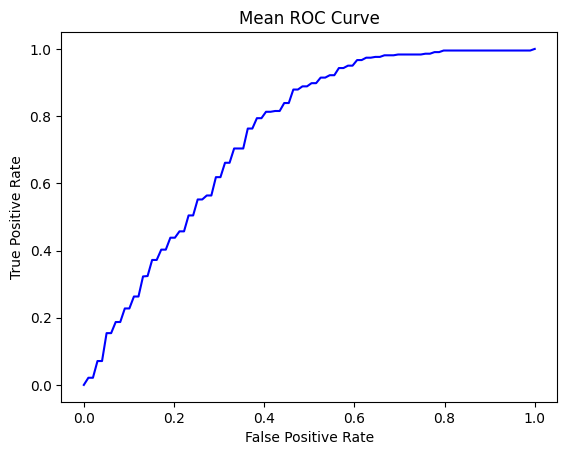

Mean AUC: 0.7441


In [18]:
# mean ROC Curve
mean_tpr = np.mean(tprs, axis=0)  
mean_tpr[-1] = 1.0  
std_auc = np.std(auc_values)  # Compute standard deviation of AUC
plt.plot(mean_fpr, mean_tpr, color='b')
plt.title("Mean ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# mean AUC
print(f"Mean AUC: {mean_auc:.4f}")


